In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

import shap
import warnings
warnings.filterwarnings('ignore')


c:\Users\vighn\anaconda3\envs\helix_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Paths
omics_dir = "OMICS DATA/"

# Load exposure and omics risk score files
exposure_df = pd.read_csv("helix_extracted.csv")
methylome = pd.read_csv(omics_dir + "methylome_risk_scores.csv")
transcriptome = pd.read_csv(omics_dir + "transcript_risk_scores.csv")
mirna = pd.read_csv(omics_dir + "mirna_risk_scores.csv")
proteome = pd.read_csv(omics_dir + "protein_risk_scores.csv")
metabolome = pd.read_csv(omics_dir + "metabolite_risk_scores.csv")
risk_weighted = pd.read_csv(omics_dir + "RISK_weighted.csv")


In [4]:
# Base dataframe
master_df = exposure_df.copy()

# Merge all omics and final risk score
dfs = [methylome, transcriptome, mirna, proteome, metabolome, risk_weighted]
for df in dfs:
    master_df = master_df.merge(df, on="ID", how="inner")

print("Final merged shape:", master_df.shape)
master_df.head()


Final merged shape: (1301, 255)


,ID,h_abs_ratio_preg_Log,h_no2_ratio_preg_Log,h_pm10_ratio_preg_None,h_pm25_ratio_preg_None,hs_no2_dy_hs_h_Log,hs_no2_wk_hs_h_Log,hs_no2_yr_hs_h_Log,hs_pm10_dy_hs_h_None,hs_pm10_wk_hs_h_None,...,protein_pregnancy_risk_y,total_protein_risk_y,transcript_child_risk_y,transcript_pregnancy_risk_y,total_transcript_risk_y,metabo_child_risk_y,metabo_pregnancy_risk_y,total_metabo_risk_y,weighted_composite_risk,risk_score
0,1,0.896711,2.872304,25.948498,17.433798,2.530279,2.583284,2.612098,22.535828,20.850005,...,-1.078877,-19.226702,-30.107535,-13.033320,-43.140855,-115.982007,-7.873317,-123.855325,-34.675909,27.084661
1,2,0.892538,2.980008,25.897739,18.470850,1.928600,2.652479,2.761064,14.077763,29.141274,...,-1.200788,-2.392757,18.861064,-5.529374,13.331690,-61.682158,-2.932099,-64.614257,-11.275298,48.359227
2,3,0.778723,3.056501,26.087347,18.711547,2.882591,2.591756,2.356163,46.859096,31.530981,...,-2.124728,-15.881561,0.113130,-12.876798,-12.763667,-86.220823,-5.629671,-91.850494,-26.126692,34.857145
3,4,0.089056,3.089157,14.991380,16.409771,1.390750,2.456717,2.403247,29.817442,25.232778,...,-1.423351,-21.826047,8.470515,8.844274,17.314789,48.929770,7.602165,56.531934,10.620562,68.265755
4,5,0.604781,3.848211,35.197296,14.889958,3.204449,3.499594,3.307663,29.817442,24.891465,...,-0.891981,-36.868356,41.536167,-0.425564,41.110603,33.479902,-3.079212,30.400690,7.777781,65.681254


In [5]:
# Continuous outcome
y_cont = master_df["risk_score"].copy()

# Binary outcome: high risk = top 25%
threshold = np.percentile(y_cont, 75)
y_bin = (y_cont >= threshold).astype(int)

print("Risk threshold for classification:", round(threshold, 3))
print("Positive class proportion:", y_bin.mean())


Risk threshold for classification: 67.31
Positive class proportion: 0.25057647963105306


In [6]:
omics_cols = [
    'total_methylome_risk_y',
    'total_transcript_risk_y',
    'total_mirna_risk_y',
    'total_protein_risk_y',
    'total_metabo_risk_y'
]

X_omics = master_df[omics_cols].copy()
X_omics.head()


,total_methylome_risk_y,total_transcript_risk_y,total_mirna_risk_y,total_protein_risk_y,total_metabo_risk_y
0,-0.389442,-43.140855,3.523050,-19.226702,-123.855325
1,-1.802544,13.331690,4.447431,-2.392757,-64.614257
2,-9.394559,-12.763667,1.017579,-15.881561,-91.850494
3,6.484507,17.314789,-5.754576,-21.826047,56.531934
4,6.827589,41.110603,5.709650,-36.868356,30.400690


In [7]:
# Drop outcome + omics
exclude = ['ID', 'risk_score', 'weighted_composite_risk'] + omics_cols
X_exposure_all = master_df.drop(columns=exclude, errors='ignore')

# Keep only numeric columns
X_exposure_numeric = X_exposure_all.select_dtypes(include=[np.number]).copy()
X_exposure_numeric.head()


,h_abs_ratio_preg_Log,h_no2_ratio_preg_Log,h_pm10_ratio_preg_None,h_pm25_ratio_preg_None,hs_no2_dy_hs_h_Log,hs_no2_wk_hs_h_Log,hs_no2_yr_hs_h_Log,hs_pm10_dy_hs_h_None,hs_pm10_wk_hs_h_None,hs_pm10_yr_hs_h_None,...,methylome_child_risk_y,methylome_pregnancy_risk_y,mirna_child_risk_y,mirna_pregnancy_risk_y,protein_child_risk_y,protein_pregnancy_risk_y,transcript_child_risk_y,transcript_pregnancy_risk_y,metabo_child_risk_y,metabo_pregnancy_risk_y
0,0.896711,2.872304,25.948498,17.433798,2.530279,2.583284,2.612098,22.535828,20.850005,31.399067,...,3.701852,-4.091294,2.465823,1.057227,-18.147825,-1.078877,-30.107535,-13.033320,-115.982007,-7.873317
1,0.892538,2.980008,25.897739,18.470850,1.928600,2.652479,2.761064,14.077763,29.141274,31.250535,...,-0.700855,-1.101689,4.701449,-0.254018,-1.191970,-1.200788,18.861064,-5.529374,-61.682158,-2.932099
2,0.778723,3.056501,26.087347,18.711547,2.882591,2.591756,2.356163,46.859096,31.530981,27.516001,...,-7.840449,-1.554110,1.452231,-0.434651,-13.756833,-2.124728,0.113130,-12.876798,-86.220823,-5.629671
3,0.089056,3.089157,14.991380,16.409771,1.390750,2.456717,2.403247,29.817442,25.232778,23.965263,...,-0.679772,7.164279,-5.937775,0.183200,-20.402696,-1.423351,8.470515,8.844274,48.929770,7.602165
4,0.604781,3.848211,35.197296,14.889958,3.204449,3.499594,3.307663,29.817442,24.891465,24.754238,...,0.059042,6.768547,7.199899,-1.490250,-35.976375,-0.891981,41.536167,-0.425564,33.479902,-3.079212


In [20]:
scaler = StandardScaler()
X_exposure_scaled = pd.DataFrame(
    scaler.fit_transform(X_exposure_numeric),
    columns=X_exposure_numeric.columns,
    index=X_exposure_numeric.index
)


# Sanity check
print("X_exposure shape:", X_exposure_scaled.shape)



X_exposure shape: (1301, 206)


## CV Training Function

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

def cross_validate_model(X, y, model, model_name, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    aucs, accs, f1s = [], [], []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        aucs.append(roc_auc_score(y_val, y_prob))
        accs.append(accuracy_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))

    return {
        'Model': model_name,
        'AUC': f"{np.mean(aucs):.3f} ± {np.std(aucs):.3f}",
        'Accuracy': f"{np.mean(accs):.3f} ± {np.std(accs):.3f}",
        'F1 Score': f"{np.mean(f1s):.3f} ± {np.std(f1s):.3f}"
    }


In [15]:
# Logistic Regression (LASSO-style)
logreg = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42)

# XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=3, learning_rate=0.1, n_estimators=100, random_state=42)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)


In [21]:
# Store results here
results = []
# Logistic Regression (LASSO-style)
logreg = LogisticRegression(
    penalty='l1',
    solver='saga',
    max_iter=5000,
    random_state=42
)


# Exposure-only
results.append(cross_validate_model(X_exposure_scaled, y_bin, logreg, "LogReg - Exposure"))
results.append(cross_validate_model(X_exposure_scaled, y_bin, xgb, "XGBoost - Exposure"))
results.append(cross_validate_model(X_exposure_scaled, y_bin, rf, "RandomForest - Exposure"))


In [22]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'AUC', 'Accuracy', 'F1 Score']]  # ordered

import IPython.display as disp
disp.display(results_df)


,Model,AUC,Accuracy,F1 Score
0,LogReg - Exposure,0.997 ± 0.001,0.968 ± 0.011,0.936 ± 0.021
1,XGBoost - Exposure,0.986 ± 0.007,0.940 ± 0.007,0.872 ± 0.015
2,RandomForest - Exposure,0.961 ± 0.013,0.875 ± 0.025,0.671 ± 0.090


##  LASSO with Cross-Validation and λ Reporting

In [18]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Run LogisticRegressionCV with L1 penalty
lasso_cv = LogisticRegressionCV(
    Cs=10,                # Try 10 values of inverse λ
    cv=5,                 # 5-fold internal CV
    penalty='l1',
    solver='saga',
    scoring='roc_auc',
    max_iter=5000,
    random_state=42,
    n_jobs=-1
)

# Scale exposure data and fit
pipeline = make_pipeline(StandardScaler(), lasso_cv)
pipeline.fit(X_exposure_numeric, y_bin)

# Best inverse regularization parameter (C), λ = 1/C
best_C = lasso_cv.C_[0]
lambda_val = 1 / best_C
print(f"🔍 Best C (inverse λ): {best_C:.4f}")
print(f"🔧 Selected λ: {lambda_val:.4f}")

# Coefficients
coef = lasso_cv.coef_.flatten()
features = X_exposure_numeric.columns

# Top non-zero predictors
nonzero_mask = coef != 0
top_features = list(zip(features[nonzero_mask], coef[nonzero_mask]))

print(f"\n📈 Non-zero predictors retained: {len(top_features)}")
for name, weight in sorted(top_features, key=lambda x: abs(x[1]), reverse=True):
    print(f"{name:50s} {weight:.4f}")


🔍 Best C (inverse λ): 0.3594
🔧 Selected λ: 2.7826

📈 Non-zero predictors retained: 65
total_metabo_risk_x                                8.1906
total_transcript_risk_x                            4.8564
total_protein_risk_x                               2.7154
methylome_child_risk_x                             1.3594
methylome_child_risk_y                             1.3594
h_clf_preg_Log                                     0.4836
metabo_child_risk_x                                0.3954
metabo_child_risk_y                                0.3954
hs_pfna_c_Log2                                     -0.3125
protein_child_risk_x                               0.3100
protein_child_risk_y                               0.3100
h_Benzene_Log                                      -0.3003
h_PM_Log                                           -0.2861
hs_hum_mt_hs_h_None                                -0.2444
hs_popdens_s_Sqrt                                  -0.2273
hs_uvdvf_mt_hs_h_None                  

In [ ]:
# Build DataFrame for LASSO plot
import pandas as pd

df_lasso = pd.DataFrame(top_features, columns=["Feature", "LASSO Coef"])
df_lasso["|LASSO Coef|"] = df_lasso["LASSO Coef"].abs()
df_lasso = df_lasso.sort_values(by="|LASSO Coef|", ascending=False).reset_index(drop=True)


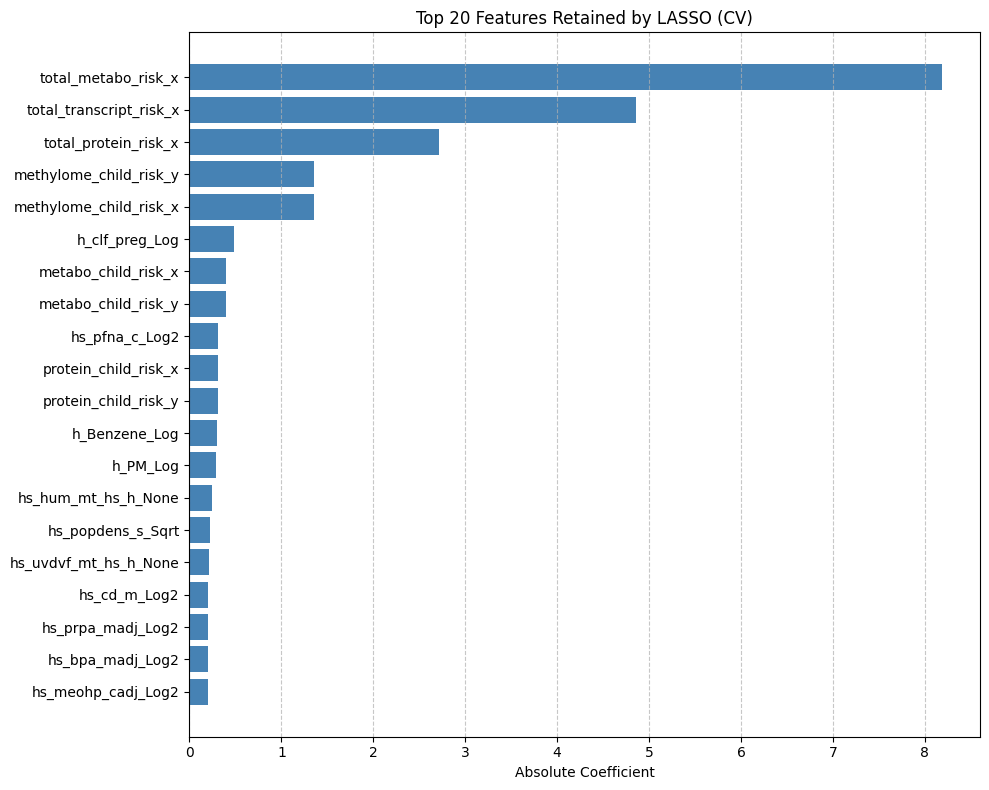

In [ ]:
import matplotlib.pyplot as plt

# Plot top 20 features by absolute LASSO coefficient
top_n = 20
df_plot = df_lasso.head(top_n).sort_values(by='|LASSO Coef|', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(df_plot['Feature'], df_plot['|LASSO Coef|'], color='steelblue')
plt.xlabel('Absolute Coefficient')
plt.title(f'Top {top_n} Features Retained by LASSO (CV)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
